# A test of the consitency of the performance of dPK
Tested on one random month in 2017 for one random zone. Trained on the 11 preceding years. Then a 52 day gap. Then tested for one month.

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy.stats import norm, skewnorm, skew
from sklearn import linear_model
import time

%load_ext autoreload
%autoreload 2

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
from koopman_probabilistic import KoopmanProb
from model_objs import SkewNLLwithTime
import vanilla_benchmark

## Pinball Loss

In [4]:
def skew_pinball_loss(data, mus, sigmas, alphas, quantiles=range(10, 100, 10)):
    assert(len(data) == len(mus))
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = skewnorm.ppf(q, alphas[i], loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [5]:
normal_pdf = lambda mu, sigma, x: np.exp(-(x - mu)**2 / (2 * sigma**2))/(np.sqrt(2 * np.pi * sigma**2))

In [6]:
def rms(x, axis=None):
    if axis is not None:
        return np.sqrt(np.sum(x**2, axis=axis) / x.shape[axis])
    return np.sqrt(np.sum(x**2) / x.size)

# load data

In [7]:
import json

with open("GEFCom2017\\GEFCom2017-Qual\\GEFCom2017QualAll.json") as f:
    all_data = json.loads(f.read())

In [8]:
dates = np.array(list(map(pd.Timestamp, all_data["ISONE CA"]["Date"])))
zones = list(all_data.keys())
print("Zones:", zones)

Zones: ['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST']


# SELECT A MONTH AND ZONE

In [9]:
zone_name = "SEMASS"
month_name = "Oct"  # <<<< CHOOSE A MONTH
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_idx = months.index(month_name)
print("Testing on month", months[month_idx])
test_start_date = pd.Timestamp(f"2017-{month_idx + 1}-01 00:00:00")
test_start = np.argwhere(dates == test_start_date)[0, 0]
test_length = 31 * 24

Testing on month Oct


In [10]:
delay_delta = pd.Timedelta(days=52)
delay = delay_delta.days * 24
train_end_date = test_start_date - delay_delta
num_years = 11
one_year = 365.24 * 24
train_start_date = train_end_date.replace(year=train_end_date.year - num_years)
train_start = np.argwhere(dates == train_start_date)[0, 0]
train_length_delta = train_end_date - train_start_date
train_through = train_length_delta.days * 24
pre_length_delta = train_length_delta * 0.5 # the length of time at the beginning of the trianing period to hide from mu
pre_length = pre_length_delta.days * 24

## Vanilla Benchmark Forecast

In [11]:
# test_start_dates = np.array(list(pd.Timestamp(f"2017-{month_idx + 1}-01 00:00:00") for month_idx in range(12)))
# train_end_dates = test_start_dates - delay_delta
# train_start_dates = list(end_date.replace(year=end_date.year - 11) for end_date in train_end_dates)
# vanilla_losses = dict()
# for zone_name in zones:
#     print("\n\nZONE:", zone_name)
#     vanilla_losses[zone_name] = []
#     for i, start_date in enumerate(train_start_dates):
#         print("testing on ", test_start_dates[i])
#         loss = vanilla_benchmark.get_lossesGEFCom(11, 31 * 24, start_date=start_date, zones=[zone_name],
#                               delay_days=delay_delta.days, plot=True)[zone_name]
#         vanilla_losses[zone_name].append(loss)
# vanilla_losses = pd.DataFrame(vanilla_losses)
# vanilla_losses["month"] = months
# vanilla_losses.to_pickle("experiments/vanilla_comp/vanilla_losses.pkl")

In [12]:
vanilla_losses = pd.read_pickle("experiments/vanilla_comp/vanilla_losses.pkl")
vanilla_losses

,ISONE CA,ME,RI,VT,CT,NH,SEMASS,WCMASS,NEMASSBOST,month
0,404.322538,28.991850,24.618092,22.845517,111.554248,35.415269,50.740262,53.850633,87.172277,Jan
1,439.179119,26.549788,27.877621,17.255753,123.341719,35.329907,61.419992,68.035331,93.743314,Feb
2,439.287499,30.992815,26.380057,24.916715,124.686462,39.072709,59.444736,64.583227,81.282889,Mar
3,262.884347,20.612047,14.836730,21.163325,68.654486,21.590003,43.379982,42.282122,50.873588,Apr
4,356.395186,18.106734,22.525307,19.104377,100.539436,29.380237,47.583941,50.520075,84.747712,May
5,650.644480,30.527894,49.153483,20.684217,196.820537,61.139079,83.553166,85.789486,137.700936,Jun
6,843.225606,40.885764,67.516006,23.722510,255.539877,74.751605,121.826118,99.725100,166.959261,Jul
7,679.210605,34.857085,53.938752,23.438780,203.212347,62.246838,98.558831,79.677067,122.551463,Aug
8,582.748297,26.458070,44.599208,23.597283,174.059924,50.764932,71.265011,80.771020,117.905531,Sep
9,295.836348,30.924309,21.041674,20.086118,77.079370,27.901953,42.660221,38.373114,61.924065,Oct


## Gather Data

In [13]:
temps_original = np.array(all_data[zone_name]["DryBulb"], dtype=np.float64)
demand = np.array(all_data[zone_name]["DEMAND"], dtype=np.float64)
x_original = demand
predict_through = train_through + delay + test_length
demand = x_original.reshape(-1, 1)

# rescale data
mean = np.mean(demand, axis=0)
rnge = np.max(demand, axis=0) - np.min(demand, axis=0)
demand = (demand - np.matlib.repmat(mean, demand.shape[0], 1)) / np.matlib.repmat(rnge, demand.shape[0], 1)
print("demand", demand.shape)

demand (113952, 1)


# GEFComKoopman forecasting using temp, time, and sinusoids

In [14]:
predict_through = train_through + delay + test_length
x = demand[train_start:]
x = x[:predict_through]
xt = x[:train_through]

In [15]:
mask = None
num_freqs = [3, 3, 3]
num_fourier = 3
year_length = 365.24 * 24
loss_weights = 1 + 0.4 * torch.cos(torch.linspace(0, 11 * 2 * np.pi, xt.shape[0]) - 2 * np.pi * (delay + test_length / 2) / year_length)
recency_weights = 1/(1 + torch.exp((3*xt.shape[0] / 4 - torch.arange(xt.shape[0])) / (xt.shape[0] / 10))) + 0.747
loss_weights *= recency_weights
print("xt", xt.shape)

num_trials = 10
relatives = []

xt (96432, 1)


fourier periods: tensor([  24.0000,  168.0000, 8765.9997], dtype=torch.float64)
Iteration  0
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  1.8880863721076542
Iteration  1
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -0.7178785666981505
Iteration  2
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.2361320719727042
Iteration  3
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.32

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.898210120625349
Iteration  36
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9015215411165396
Iteration  37
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9036263381918583
Iteration  38
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.907524784016261
Iteration  39
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9521668392479696
Iteration  66
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9530270202868711
Iteration  67
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9644386216022527
Iteration  82
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 876

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9726817313553515
Iteration  95
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.973964676466782
Iteration  96
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large 

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9801202410612757
Iteration  108
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 87

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9856425552344183
Final loss: -1.9856425552344183


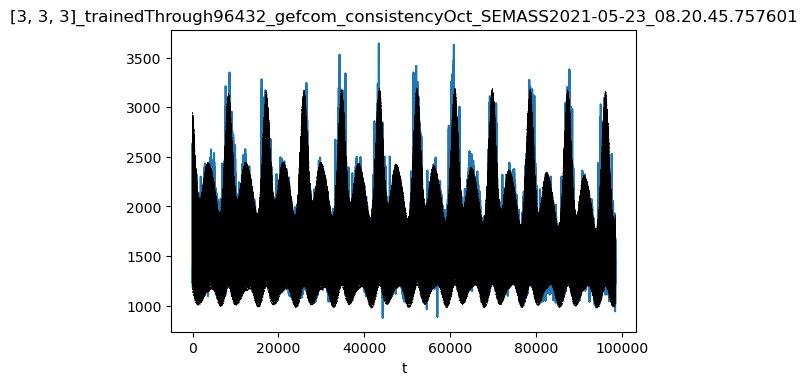

pinball_loss: 31.777568760257378
25.51006952066124% performance relative to vanilla benchmark





fourier periods: tensor([  24.0000,  168.0000, 8765.9997], dtype=torch.float64)
Iteration  0
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  1.95900394529347
Iteration  1
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -0.6453777888435881
Iteration  2
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.2463040982601925
Iteration  3
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  16

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8781232458817443
Iteration  35
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8803483228506497
Iteration  36
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.88257247654559
Iteration  37
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8833585448075243
Iteration  38
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.920427911722593
Iteration  70
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.92209558316869
Iteration  71
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.923460251015698
Iteration  72
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9242960631105774
Iteration  73
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 87

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9581766992537375
Iteration  100
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.959053071099598
Iteration  101
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 876

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9710647448034326
Iteration  119
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9721040906135094
Final loss: -1.9721040906135094


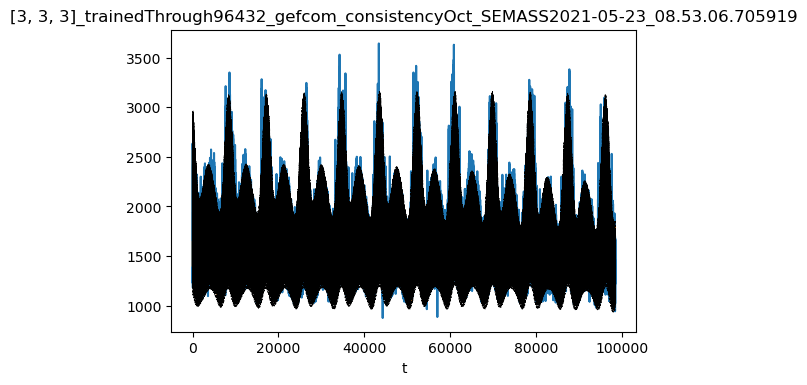

pinball_loss: 32.393642174767464
24.065929279371943% performance relative to vanilla benchmark





fourier periods: tensor([  24.0000,  168.0000, 8765.9997], dtype=torch.float64)
Iteration  0
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  1.9888142625664162
Iteration  1
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -0.4504174450972266
Iteration  2
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.1879042110770863
Iteration  3
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24., 

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.891995190261107
Iteration  35
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8950264801455008
Iteration  36
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.896499995415384
Iteration  37
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8991462851225946
Iteration  38
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.941545826484173
Iteration  68
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9431764501985584
Iteration  69
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large 

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.957259300174047
Iteration  85
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical ins

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9660014333433398
Iteration  97
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9661531057178612
Iteration  98
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.973242803768242
Iteration  110
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical in

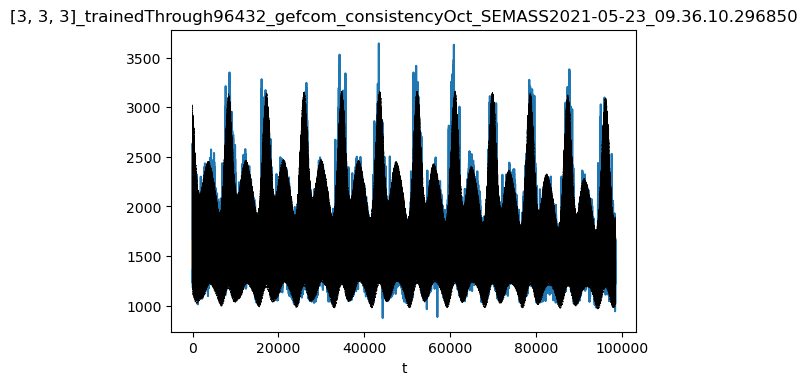

pinball_loss: 32.65081008322493
23.46310092056837% performance relative to vanilla benchmark





fourier periods: tensor([  24.0000,  168.0000, 8765.9997], dtype=torch.float64)
Iteration  0
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  1.8409627073974852
Iteration  1
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -0.587724627401362
Iteration  2
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.261943030417439
Iteration  3
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8838350383321496
Iteration  35
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8859936347124484
Iteration  36
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8883929082225903
Iteration  37
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.889241089720578
Iteration  38
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168.,

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9306030073413638
Iteration  70
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9311345632131371
Iteration  71
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9320474645613017
Iteration  72
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       gra

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9457749644158313
Iteration  91
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9468889384513857
Iteration  92
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9465423691395716
Iteration  93
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.955528196684504
Iteration  107
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9575756408020546
Iteration  108
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (larg

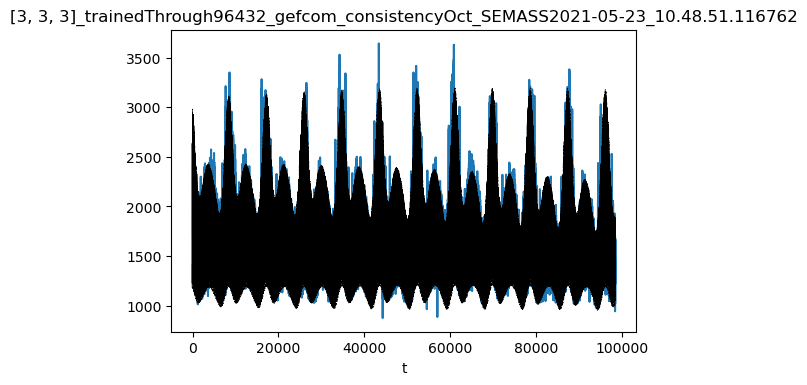

pinball_loss: 34.05332797320679
20.175452928710758% performance relative to vanilla benchmark





fourier periods: tensor([  24.0000,  168.0000, 8765.9997], dtype=torch.float64)
Iteration  0
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  1.9890167398609782
Iteration  1
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -0.47390817634454235
Iteration  2
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.1837167471094006
Iteration  3
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24., 

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.879631472175981
Iteration  35
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8818952473714252
Iteration  36
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8834221818497756
Iteration  37
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.885625452840105
Iteration  38
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9327412634694168
Iteration  70
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.933982952842681
Iteration  71
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9362978460535023
Iteration  72
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9365719233535217
Iteration  73
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168.,

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.958396960725024
Iteration  94
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9592406510401175
Iteration  95
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large 

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9694733765444403
Iteration  111
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9693947191711831
Iteration  112
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (lar

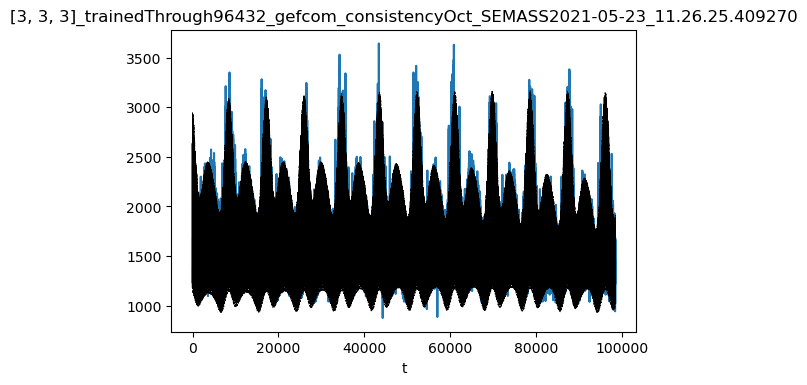

pinball_loss: 32.289876014744586
24.30916796463849% performance relative to vanilla benchmark





fourier periods: tensor([  24.0000,  168.0000, 8765.9997], dtype=torch.float64)
Iteration  0
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  2.0736932149917378
Iteration  1
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -0.3277365689517077
Iteration  2
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.2286613448983277
Iteration  3
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8703279781044138
Iteration  35
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.872825985653912
Iteration  36
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.87558214203262
Iteration  37
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.877385370616448
Iteration  38
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 87

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.923656808793569
Iteration  70
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9259593740188343
Iteration  71
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9261867215940243
Iteration  72
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9282916263546415
Iteration  73
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168.,

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9544717810789742
Iteration  98
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9547137654224953
Iteration  99
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.965000181763668
Iteration  116
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9654413848640586
Iteration  117
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 876

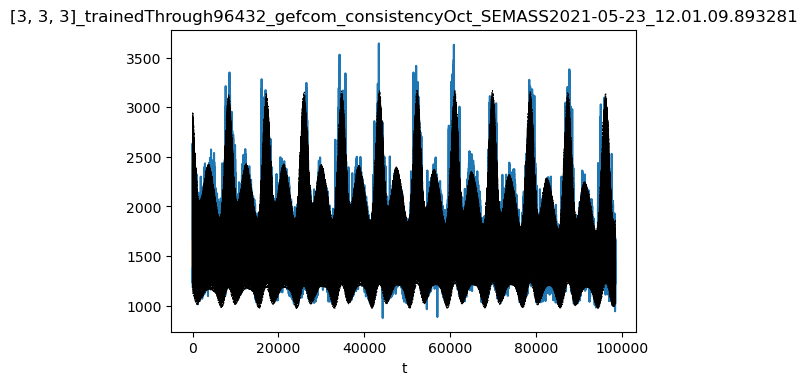

pinball_loss: 32.27262415527639
24.349608119834766% performance relative to vanilla benchmark





fourier periods: tensor([  24.0000,  168.0000, 8765.9997], dtype=torch.float64)
Iteration  0
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  2.0034525321125938
Iteration  1
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -0.41004073872326446
Iteration  2
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.2282102018806516
Iteration  3
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24., 

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8765078080982542
Iteration  35
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.877682937740081
Iteration  36
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8787522352782957
Iteration  37
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8812287160574908
Iteration  38
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168.,

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9244501394930305
Iteration  70
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9277600001129287
Iteration  71
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9291000300645778
Iteration  72
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.929847448700647
Iteration  73
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168.,

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9688993850788261
Iteration  103
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9691763951465848
Iteration  104
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.96924222

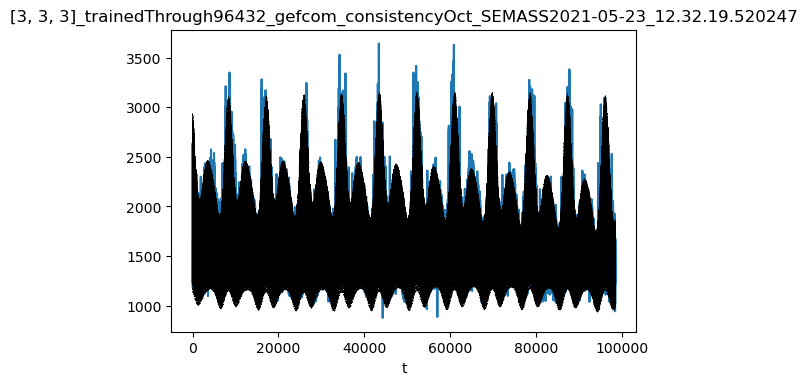

pinball_loss: 32.5099212792485
23.79335894920166% performance relative to vanilla benchmark





fourier periods: tensor([  24.0000,  168.0000, 8765.9997], dtype=torch.float64)
Iteration  0
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  1.890417553552396
Iteration  1
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -0.5842887686516525
Iteration  2
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.2922955798670028
Iteration  3
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8690809554296375
Iteration  35
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8712465164683412
Iteration  36
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8736753036353537
Iteration  37
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8762469353404851
Iteration  38
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168.

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9103537228377632
Iteration  70
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9113174747937127
Iteration  71
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9115594741862445
Iteration  72
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9124436242517073
Iteration  73
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168.

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.955049615403777
Iteration  105
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9559344187005214
Iteration  106
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9577549554544342
Iteration  107
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Se

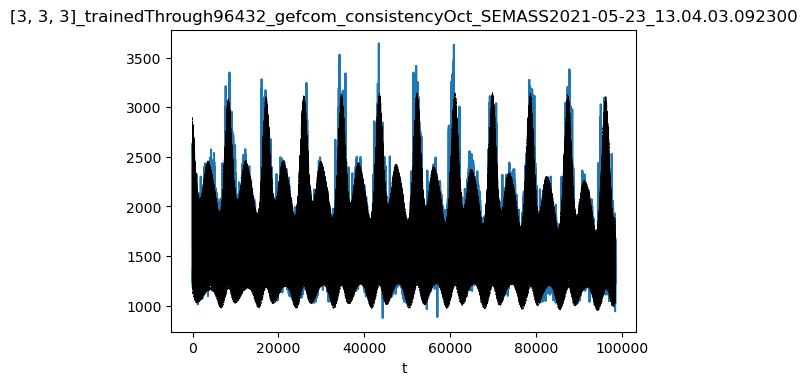

pinball_loss: 32.5974947980513
23.58807750125118% performance relative to vanilla benchmark





fourier periods: tensor([  24.0000,  168.0000, 8765.9997], dtype=torch.float64)
Iteration  0
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  2.0195936017758016
Iteration  1
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -0.4329417199905926
Iteration  2
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.2267703193907629
Iteration  3
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  16

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9091711235802944
Iteration  35
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9114764977837828
Iteration  36
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9146100262944796
Iteration  37
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9153126814058123
Iteration  38
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168.

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.948466870312571
Iteration  68
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9486229434651392
Iteration  69
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9611701165352409
Iteration  88
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9624273603937339
Iteration  89
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9615664504

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9712989120308437
Iteration  108
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9721224335186678
Iteration  109
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (lar

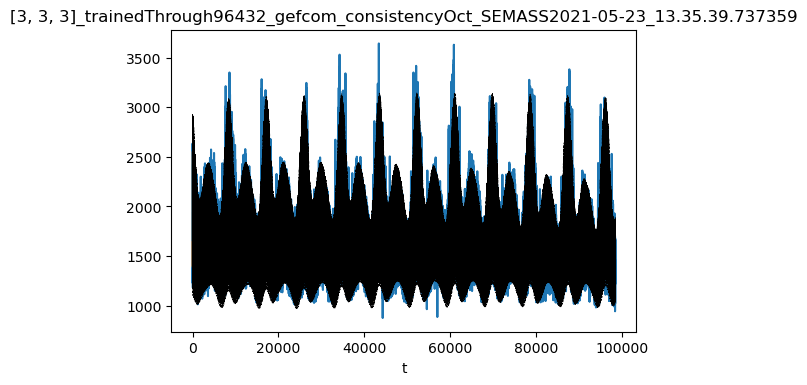

pinball_loss: 33.04487503244731
22.539371641800187% performance relative to vanilla benchmark





fourier periods: tensor([  24.0000,  168.0000, 8765.9997], dtype=torch.float64)
Iteration  0
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  1.6351368693846495
Iteration  1
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -0.9159333471284005
Iteration  2
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.2519003579392807
Iteration  3
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8773662410815413
Iteration  35
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8793783677214073
Iteration  36
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8817806108963364
Iteration  37
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.8830804823132812
Iteration  38
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168.

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9074597956049002
Iteration  70
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9076743428136071
Iteration  71
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9081809551074673
Iteration  72
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9086296645547316
Iteration  73
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168.

Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9311226926585525
Iteration  105
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.932775145743417
Iteration  106
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9339582426198694
Iteration  107
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.],
       grad_fn=<MulBackward0>)
Loss:  -1.9366448259369549
Iteration  108
tensor([  24.,  168., 8766.,   24.,  168., 8766.,   24.,  168., 8766.])
Setting periods to tensor([  24.,  168., 8766.,   24.,  1

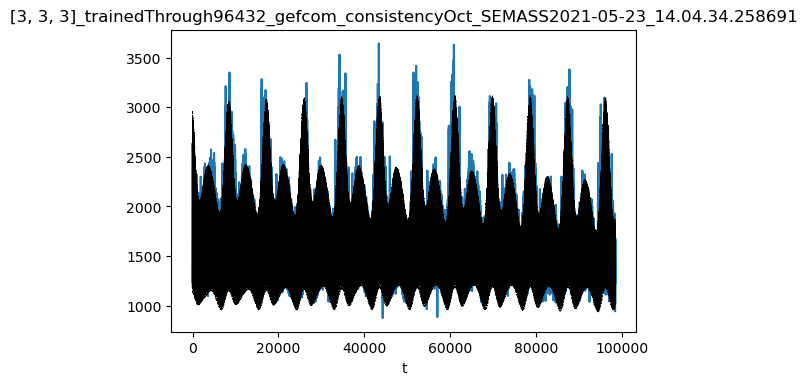

pinball_loss: 32.5676486589353
23.65803995950596% performance relative to vanilla benchmark







In [16]:
for i in range(num_trials):
    now = ("_".join(str(datetime.now()).split())).replace(":", ".")
    data_name = "gefcom_consistency" + month_name + "_" + zone_name + now
    name_prefix = "./experiments/gefcom-consistency/" + data_name + f"trained{train_start}-{train_through}_"

    ### TRAIN ###
    model = SkewNLLwithTime(x_dim=xt.shape[1], num_freqs=num_freqs, n=254)
    k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32, loss_weights=loss_weights)

    k.find_fourier_omegas(xt, hard_code=[24, 168, 24 * 365.25])
    np.save(name_prefix + "observed.npy", x_original[train_start:][:predict_through])

    k.fit(xt, iterations=120, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0,
          training_mask=mask);
    
    params = k.predict(predict_through)
    mu_hat, sigma_hat, a_hat = params

    # rescale
    test_start = train_through + delay
    sigh, ah = sigma_hat, a_hat
    delta = ah / np.sqrt(1 + ah ** 2)
    muh = mu_hat * rnge + (rnge - 1) * delta * sigh * np.sqrt(2 / np.pi)
    muh = muh + mean - (rnge - 1) * delta * sigh * np.sqrt(2 / np.pi)
    sigh = sigh * rnge

    mean_hat = model.mean([muh, sigh, ah])
    std_hat = model.std([muh, sigh, ah])

    np.save(name_prefix + "mu_hat.npy", muh)
    np.save(name_prefix + "sigma_hat.npy", sigh)
    np.save(name_prefix + "alpha_hat.npy", ah)
    
    plt.figure(dpi=100)
    plt.subplot(111)
    dim=0
    plt.plot(x_original[train_start:][:predict_through])
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    # plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    # plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    # plt.legend()
    plt.show()
    
    loss = skew_pinball_loss(x_original[train_start:][test_start: predict_through], muh[test_start:], sigh[test_start:], ah[test_start:])[0]
    relatives.append((1 - loss/vanilla_losses[zone_name].iloc[month_idx]) * 100)
    print("pinball_loss:", loss)
    print(f"{relatives[-1]}% performance relative to vanilla benchmark" + "\n"*5)

In [17]:
relatives

[25.51006952066124,
 24.065929279371943,
 23.46310092056837,
 20.175452928710758,
 24.30916796463849,
 24.349608119834766,
 23.79335894920166,
 23.58807750125118,
 22.539371641800187,
 23.65803995950596]

In [18]:
relatives = np.array(relatives)

In [19]:
relatives.mean()

23.545217678554458

In [20]:
relatives.std()

1.3346299545886127

In [24]:
relatives.std()/np.sqrt(108)

0.4170413882796201

In [23]:
vanilla_losses

,ISONE CA,ME,RI,VT,CT,NH,SEMASS,WCMASS,NEMASSBOST,month
0,404.322538,28.991850,24.618092,22.845517,111.554248,35.415269,50.740262,53.850633,87.172277,Jan
1,439.179119,26.549788,27.877621,17.255753,123.341719,35.329907,61.419992,68.035331,93.743314,Feb
2,439.287499,30.992815,26.380057,24.916715,124.686462,39.072709,59.444736,64.583227,81.282889,Mar
3,262.884347,20.612047,14.836730,21.163325,68.654486,21.590003,43.379982,42.282122,50.873588,Apr
4,356.395186,18.106734,22.525307,19.104377,100.539436,29.380237,47.583941,50.520075,84.747712,May
5,650.644480,30.527894,49.153483,20.684217,196.820537,61.139079,83.553166,85.789486,137.700936,Jun
6,843.225606,40.885764,67.516006,23.722510,255.539877,74.751605,121.826118,99.725100,166.959261,Jul
7,679.210605,34.857085,53.938752,23.438780,203.212347,62.246838,98.558831,79.677067,122.551463,Aug
8,582.748297,26.458070,44.599208,23.597283,174.059924,50.764932,71.265011,80.771020,117.905531,Sep
9,295.836348,30.924309,21.041674,20.086118,77.079370,27.901953,42.660221,38.373114,61.924065,Oct
